In [1]:
from Bio.PDB import Chain, Entity, PDBIO, PDBParser
from copy import deepcopy
from matplotlib import pyplot as plt
import numpy as np
import os
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

In [2]:
parser = PDBParser()

In [3]:
structure = parser.get_structure(0, "/Users/fonturacetamum/Projects/catch_bonds/1sq0/infiles/in.pdb")

There are two chains in the system: vWF and GPIb$\alpha$.  
According to (Springer, 2014), in order to detect catch-bond behavior, we should pull C-terminus of GPIb$\alpha$ away from N-terminus of vWF. Let's draw a line between twe termini and sample points from two circles to place two dummy aminoacids. These aminoacids will determine where exactly pulling force will be directed.

In [4]:
vWF, gp1ba, _ = structure.get_chains()

In [5]:
for r in vWF.get_residues():
    n_term_vWF = r
    break
n_term_vWF = [a for a in n_term_vWF if a.get_fullname().strip() == "CA"][0]
n_term_vWF_coords = n_term_vWF.get_coord()


for r in gp1ba.get_residues():
    c_term_gp1ba = r
c_term_gp1ba = [a for a in c_term_gp1ba if a.get_fullname().strip() == "CA"][0]
c_term_gp1ba_coords = c_term_gp1ba.get_coord()

In [6]:
TARGET_DISTANCE = 100
EPS = 1e-3
MAX_ANGLE = 15 # degrees

In [7]:
diff_vector = n_term_vWF_coords - c_term_gp1ba_coords
distance = np.linalg.norm(diff_vector)
diff_vector_target_len = diff_vector * (TARGET_DISTANCE / distance)
n_further = n_term_vWF_coords + diff_vector_target_len
c_further = c_term_gp1ba_coords - diff_vector_target_len

We need to generate points from two circles, let's try to do so and ensure that we have the right distribution.

In [8]:
sampled_angles = []

for _ in range(10000):
    n_vector = n_further - n_term_vWF_coords
    n_vector_norm = n_vector / np.linalg.norm(n_vector)

    # Find an orthonormal basis for vectors orthogonal to n_vector
    x_basis = np.random.randn(3)
    x_basis -= x_basis.dot(n_vector_norm) * n_vector_norm
    x_basis /= np.linalg.norm(x_basis)
    y_basis = np.cross(n_vector_norm, x_basis)

    # For uniform sampling from a circle let's sample in polar coordinates
    r_sample, phi_sample = np.random.rand(2)
    r_sample *= TARGET_DISTANCE * np.tan(MAX_ANGLE / 180 * np.pi)
    phi_sample *= 2 * np.pi
    x_coef = r_sample * np.cos(phi_sample)
    y_coef = r_sample * np.sin(phi_sample)

    sampled_vector = x_coef * x_basis + y_coef * y_basis
    if np.abs(np.dot(n_vector, sampled_vector)) > EPS:
        print("Could not build a perpendicular vector.")
        continue
    sampled_point = n_further + sampled_vector

    v1 = n_term_vWF_coords - sampled_point
    v2 = n_term_vWF_coords - n_further
    sampled_angle = np.arccos(np.dot(v1, v2) / np.linalg.norm(v1) / np.linalg.norm(v2)) * 180 / np.pi
    sampled_angles.append(sampled_angle)

Could not build a perpendicular vector.
Could not build a perpendicular vector.
Could not build a perpendicular vector.
Could not build a perpendicular vector.
Could not build a perpendicular vector.
Could not build a perpendicular vector.
Could not build a perpendicular vector.
Could not build a perpendicular vector.
Could not build a perpendicular vector.
Could not build a perpendicular vector.


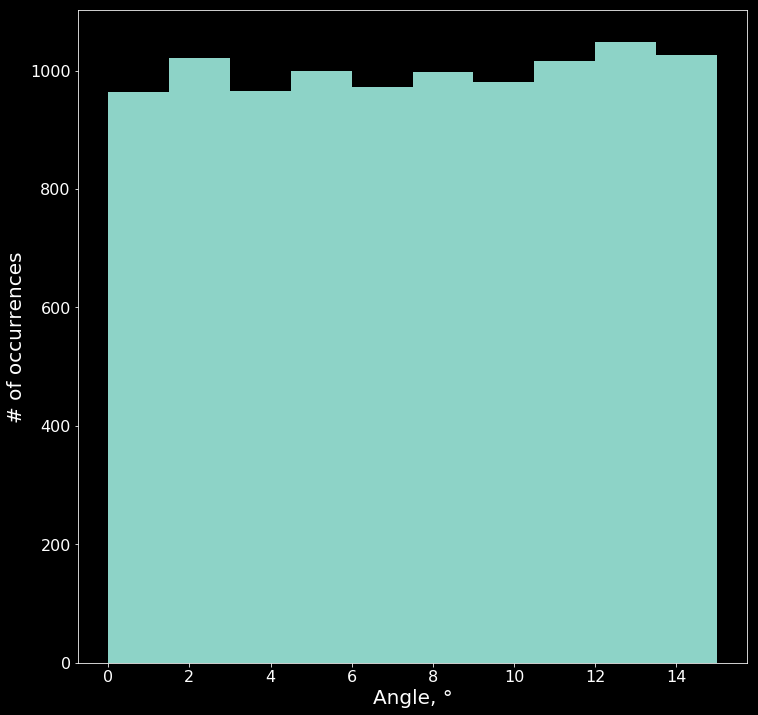

In [9]:
plt.style.use('dark_background')
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1)
fig.patch.set_facecolor("xkcd:black")
ax.hist(sampled_angles)
[t.set_fontsize(16) for t in ax.get_xticklabels()]
_ = ax.set_xlabel("Angle, °", fontdict={"size": 20})
[t.set_fontsize(16) for t in ax.get_yticklabels()]
_ = ax.set_ylabel("# of occurrences", fontdict={"size": 20})

We do have uniform distribution of angles. We can use sampled points as coordinates of CA atom of dummy aminoacids.

In [10]:
def sample_perp_vector(vector):
    vector_length = np.linalg.norm(vector)
    vector_norm = vector / vector_length
    
    # Find an orthonormal basis for vectors orthogonal to n_vector
    x_basis = np.random.randn(3)
    x_basis -= x_basis.dot(n_vector_norm) * n_vector_norm
    x_basis /= np.linalg.norm(x_basis)
    y_basis = np.cross(n_vector_norm, x_basis)
    
    # For uniform sampling from a circle let's sample in polar coordinates
    r_sample, phi_sample = np.random.rand(2)
    r_sample *= vector_length * np.tan(MAX_ANGLE / 180 * np.pi)
    phi_sample *= 2 * np.pi
    x_coef = r_sample * np.cos(phi_sample)
    y_coef = r_sample * np.sin(phi_sample)

    sampled_vector = x_coef * x_basis + y_coef * y_basis
    if np.abs(np.dot(n_vector, sampled_vector)) > EPS:
        print("Could not build a perpendicular vector.")
        return None
    
    return sampled_vector

In [11]:
c_dummy_ca_coord = sample_perp_vector(diff_vector_target_len) + n_further
d_dummy_ca_coord = sample_perp_vector(diff_vector_target_len) + c_further

structure = parser.get_structure(0, "../1sq0/infiles/in.pdb")

chain_c = [c for c in structure.get_chains()][-1]
chain_d = Chain.Chain("D")
chain_d.add(deepcopy(chain_c.child_dict[(" ", 1, " ")]))
m = structure.child_dict[0]
m.add(chain_d)
chain_c.transform(np.eye(3), c_dummy_ca_coord - chain_c.child_dict[(" ", 1, " ")].child_dict["CA"].get_coord())
chain_d.transform(np.eye(3), d_dummy_ca_coord - chain_d.child_dict[(" ", 1, " ")].child_dict["CA"].get_coord())

pdb_io = PDBIO()
pdb_io.set_structure(structure)
dirname = "../1sq0/infiles/"
pdb_io.save(os.path.join(dirname, "test_sampling.pdb"))